In [152]:
#gather original df

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats

#get plots to show up in jn
%matplotlib inline
#get plots to be an svg when exporting
%config InlineBackend.figure_format = 'svg'

In [81]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
# week_nums = [180407, 180414, 180421, 180428, 180505, 180512, 180519, 180526, 180602, 180609, 180616, 180623]
week_nums = [180407, 180414, 180421, 180428]
data = get_data(week_nums)
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,00:00:00,REGULAR,6566463,2224050
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,04:00:00,REGULAR,6566470,2224053
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,08:00:00,REGULAR,6566470,2224053
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,12:00:00,REGULAR,6566470,2224055
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,16:00:00,REGULAR,6566470,2224055


In [82]:
#cleaning up data

df = data.copy()

df.columns = [column.strip() for column in df.columns]

df['STATION'].apply(lambda x: x.strip());

In [83]:
#get datetime column
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")

#drop dupes

df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)

df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

df = df.drop(["EXITS", "DESC"], axis=1, errors="ignore");

In [84]:
#sort so prev entries will work
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False));

In [85]:
#put in prev entries column
df_daily = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
.ENTRIES.first().reset_index().copy()

df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].transform(lambda grp: grp.shift(1)));

In [86]:
#fix daily counts

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        # if current entries is bad, use yesterday's count as proxy
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

df_daily.apply(get_daily_counts, axis=1, max_counter=1000000);

In [87]:
#subtract prev values to make daily entries column
df_daily["DAILY_ENTRIES"] = df_daily.apply(get_daily_counts, axis=1, max_counter=1000000);

In [88]:
df_daily_sta = df_daily.groupby(['STATION', 'DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DATE'])
df_daily_sta.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,03/31/2018,NaN
3583,AVENUE N,03/31/2018,NaN
3611,AVENUE P,03/31/2018,NaN
3639,AVENUE U,03/31/2018,NaN
3667,AVENUE X,03/31/2018,NaN


In [89]:
df_sta = df_daily_sta.groupby(['STATION'])['DAILY_ENTRIES'].sum().reset_index()

In [90]:
df_sta_top_all = df_sta.sort_values('DAILY_ENTRIES', ascending = False)[:20]

In [91]:
top_stations_all = df_sta_top_all.STATION

df_daily_sta_top_20 = df_daily_sta.loc[df_daily_sta.STATION.isin(top_stations_all), :]

In [92]:
df_daily_sta_top_20.head()

,STATION,DATE,DAILY_ENTRIES
2995,86 ST,03/31/2018,NaN
3135,96 ST,03/31/2018,NaN
4927,CHAMBERS ST,03/31/2018,NaN
4759,CANAL ST,03/31/2018,NaN
1259,23 ST,03/31/2018,NaN


In [93]:
# dates = df_daily_sta_top_20.DATE

plot_df = df_daily_sta_top_20.groupby(['STATION'])['DAILY_ENTRIES'].sum().reset_index().sort_values('DAILY_ENTRIES', ascending = False)

plot_df = plot_df.reset_index()

plot_df = plot_df.drop('index', axis = 1)
# plt.xticks(rotation = 90)


plot_df.head()

# plot_df.STATION.head()

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,3986754.0
1,GRD CNTRL-42 ST,3533970.0
2,34 ST-HERALD SQ,3007648.0
3,23 ST,2828589.0
4,14 ST-UNION SQ,2591319.0


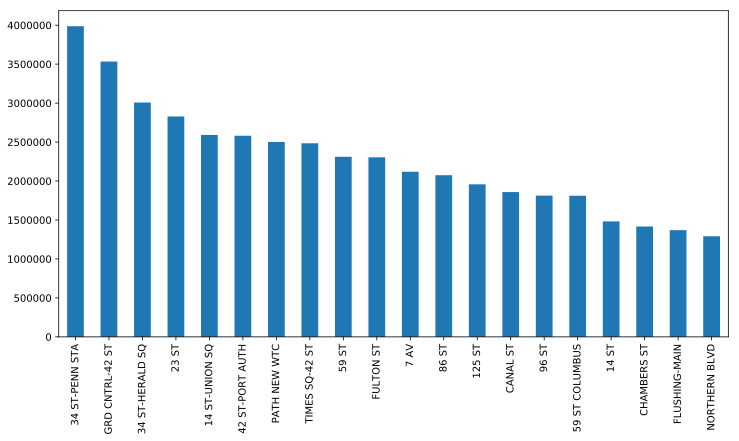

In [94]:
plt.figure(figsize = (12, 6))


ax = plot_df.DAILY_ENTRIES.plot(kind = 'bar', x = plot_df.STATION)

ax.set_xticklabels(plot_df.STATION);

# plt.bar(plot_df.STATION, plot_df.DAILY_ENTRIES,)
# plt.xticks(rotation = 90)




#this was an attempt at grouping by station
# dfs = [df_daily_sta_top_20.loc[df_daily_sta_top_20.STATION == station, :] for station in df_daily_sta_top_20.STATION.unique()]

# dftest = df_daily_sta_top_20.loc[df_daily_sta_top_20.STATION == '23 ST', :]

# # group_labels = dates
# # .plot(figsize = (12, 6)).bar()

__OK, but what about per week?__

In [121]:
#Insert weeks

df_weekly = df_daily.copy()

df_weekly['DATE_TIME'] = pd.to_datetime(df_weekly['DATE'], format="%m/%d/%Y")

df_weekly['WEEK'] = df_weekly['DATE_TIME'].apply(lambda date: date.strftime("%V"))

df_weekly.head()




,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DATE_TIME,WEEK
0,A002,R051,02-00-00,59 ST,03/31/2018,6566470,NaN,NaN,NaN,2018-03-31,13
1,A002,R051,02-00-00,59 ST,04/01/2018,6566470,03/31/2018,6566470.0,0.0,2018-04-01,13
2,A002,R051,02-00-00,59 ST,04/02/2018,6567469,04/01/2018,6566470.0,999.0,2018-04-02,14
3,A002,R051,02-00-00,59 ST,04/03/2018,6568775,04/02/2018,6567469.0,1306.0,2018-04-03,14
4,A002,R051,02-00-00,59 ST,04/04/2018,6570115,04/03/2018,6568775.0,1340.0,2018-04-04,14


In [156]:
#group ridership by week for each station

def add_math_column(df_to_column, func, new_column_name, original_data = df_weekly, timeframe = 'WEEK', affected_column = 'DAILY_ENTRIES'):
    '''
    adds to a df that has already been grouped a column of same groupings with other operation
    
    inputs 
        original data to agg on (df)
        
        timeframe to agg on (string, must be name of column)
        
        func to agg on (string, must not have end parens)
        
        affected_column being agged on (string, must be name of column)
        
        new_column_name to append (string)
        
        df_to_column is df to append column to (df)
        
    outputs
        df_to_column with agged column (df)
    
    '''
    
    func_df = original_data.groupby(['STATION', timeframe])[affected_column].agg([func]).reset_index()
    
    df_to_column[new_column_name] = func_df[affected_column]
    
    print(df_to_column.head())
    
    return df_to_column

df_weekly_means = df_weekly.groupby(['STATION', 'WEEK'])['DAILY_ENTRIES'].agg(['sum','count','mean', 'std', 'median', stats.iqr]).reset_index()
print(df_weekly_means.head())

# df_weekly_std = df_weekly.groupby(['STATION', 'WEEK'])['DAILY_ENTRIES'].std().reset_index()
# print(df_weekly_std.head())

# add_math_column(original_data = df_weekly, df_to_column = df_weekly_means, func = 'mean', new_column_name = 'WEEKLY_MEANS')

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


  STATION WEEK       sum  count         mean          std  median      iqr
0    1 AV   13   13367.0     10  1336.700000  1083.812412   951.5      NaN
1    1 AV   14  133368.0     70  1905.257143  1408.236524  1334.0  2423.00
2    1 AV   15  148902.0     70  2127.171429  1571.506284  1373.0  2601.25
3    1 AV   16  150093.0     70  2144.185714  1566.381765  1481.0  2573.75
4    1 AV   17  112344.0     50  2246.880000  1655.151102  1493.0  2851.75


In [124]:
#get mean and std; median and IQR

# df_weekly.groupby(['STATION','WEEK'])['WEEKLY_ENTRIES'].mean().reset_index()

# df_weekly.groupby(['WEEK','STATION'])['WEEKLY_ENTRIES'].mean().head(10)



Index(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'ENTRIES', 'PREV_DATE',
       'PREV_ENTRIES', 'DAILY_ENTRIES', 'DATE_TIME', 'WEEK', 'new column'],
      dtype='object')

   views  orders
0     23     123
1    135     500
2      3       1
views      53.666667
orders    208.000000
dtype: float64


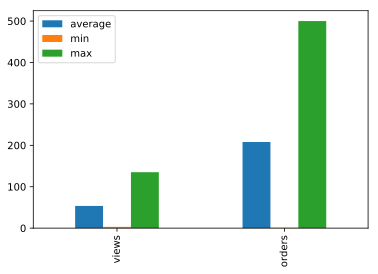

In [17]:
#a graph that looks pretty

# import pandas as pd

# groups = [[23,135,3], [123,500,1]]
# group_labels = ['views', 'orders']

# # Convert data to pandas DataFrame.
# df = pd.DataFrame(groups, index=group_labels).T
# print(df)

# print(df.mean())
# # Plot.
# pd.concat(
#     [df.mean().rename('average'), df.min().rename('min'), 
#      df.max().rename('max')],
#     axis=1).plot.bar()

In [18]:
df_daily_sta.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,03/31/2018,NaN
3583,AVENUE N,03/31/2018,NaN
3611,AVENUE P,03/31/2018,NaN
3639,AVENUE U,03/31/2018,NaN
3667,AVENUE X,03/31/2018,NaN


In [19]:
df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
0,A002,R051,02-00-00,59 ST,03/31/2018,6566470,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,04/01/2018,6566470,03/31/2018,6566470.0,0.0
2,A002,R051,02-00-00,59 ST,04/02/2018,6567469,04/01/2018,6566470.0,999.0
3,A002,R051,02-00-00,59 ST,04/03/2018,6568775,04/02/2018,6567469.0,1306.0
4,A002,R051,02-00-00,59 ST,04/04/2018,6570115,04/03/2018,6568775.0,1340.0


In [20]:
testdf = pd.DataFrame({
    "x": np.random.choice(range(2001, 2008), 250),
    "w": np.random.uniform(50, 400, 250),
    "cat": np.random.choice(["A", "B", "C", "D", "E"], 250)
})
testdf.head()

,cat,w,x
0,D,68.521879,2001
1,D,348.090022,2001
2,C,341.028010,2007
3,E,59.437381,2003
4,A,396.403647,2002
